# Vegetation detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_TILES, TRAIN_LABEL_TILES, get_image_tile_data, normalize, make_ratios_vegetation
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2

### Input data

Images of shape (512, 512, 17) 

In [5]:
from unet import unet_one

Using Theano backend.


Keras user configuration is setup


In [6]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [7]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [8]:
RESIZE_TILES = True
tile_size = (128, 128)
channels = np.array(range(17))
# channels = np.array([0, 1, 2, 3, 5, 6, 7])
n_channels = len(channels)
# labels = np.array(range(len(LABELS)))
labels = np.array([0, 5, 6, 2])
n_labels = len(labels)

deep=False 
n_filters_0=8

model = unet_one(n_labels, n_channels, *tile_size, deep=deep, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "unet_one_%i_%i_%s_%i.h5.store" % (n_channels, n_labels, str(deep), n_filters_0))
if os.path.exists(weights_filename):
    print "Found weights file %s" % weights_filename
    model.load_weights(weights_filename)

In [9]:
channels, labels, np.array(LABELS)[labels]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([0, 5, 6, 2]),
 array(['None', 'Trees', 'Crops', 'Misc. Manmade structures'], 
       dtype='|S24'))

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 17, 128, 128)  0                                            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 17, 128, 128)  512         input_1[0][0]                    
____________________________________________________________________________________________________
inverse_1 (Inverse)              (None, 17, 128, 128)  0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 8, 128, 128)   1232        batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [11]:
import os
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

In [12]:
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_TILES, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_TILES)+1:] for s in all_train_tiles])

In [13]:
all_train_tiles[0]

'6010_1_2_0_0.tif'

In [14]:
from sklearn.model_selection import train_test_split 

# TRAIN ON N TILES
n_tiles = -1
if n_tiles > 0:
    train_tiles, val_tiles = train_test_split(all_train_tiles[:n_tiles], test_size=0.3)
else:
    train_tiles, val_tiles = train_test_split(all_train_tiles, test_size=0.3)
    
print len(train_tiles), len(val_tiles)

1120 480


In [15]:
def normalize_image(img_data, max_value=1.0):
    if RESIZE_TILES:
        out = cv2.resize(img_data, dsize=tile_size, interpolation=cv2.INTER_CUBIC).astype(np.float32)
        if len(out.shape) == 2:
            out = out[:, :, None]
    else:
        out = img_data.astype(np.float32)

    if max_value > 1.0:  
        out = normalize(out, 0.01, 99.9)        
    
    out = out.transpose([2,0,1])
    return out


def generate_images(train_tiles, batch_size, print_tile_id=False):
    while True:
        n = len(train_tiles)
        n_batches = n // batch_size
        random_indices = np.arange(n)
        np.random.shuffle(random_indices)
        for i in range(n_batches):
            end = min((i+1)*batch_size, n) 
            batch_indices = random_indices[batch_size*i:end]
            X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
            Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
            for j, tile_id in enumerate(train_tiles[batch_indices]):
                if print_tile_id:
                    print("Tile id: %s" % tile_id)
                x = get_image_tile_data(os.path.join(TRAIN_TILES,tile_id))
                y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))
                
                if n_labels < len(LABELS) - 1:
                    y = y[:,:,labels]
                if n_channels < 17:
                    x = x[:,:,channels]

                x = normalize_image(x)
                y = normalize_image(y)     
                
                X[j,:,:,:] = x
                Y[j,:,:,:] = y 
                
            yield (X, Y)

Tile id: 6170_0_4_832_832.tif
Tile id: 6040_1_3_832_384.tif
Tile id: 6110_1_2_384_384.tif
Tile id: 6010_4_2_2624_2624.tif
Tile id: 6040_2_2_1728_1728.tif
(5, 17, 128, 128) (5, 4, 128, 128)
87.0 2204.0 0.0 1.0


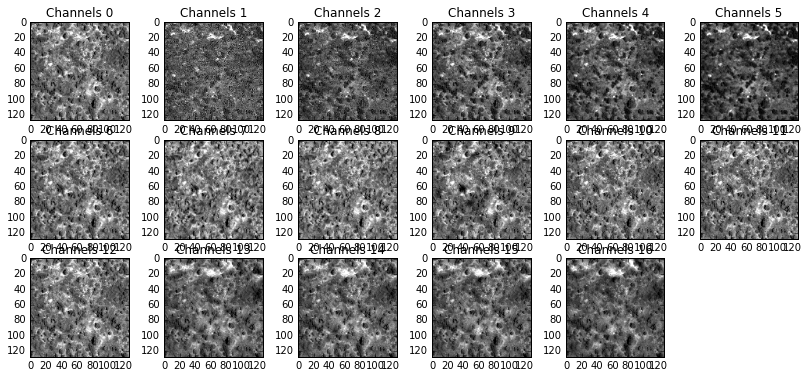

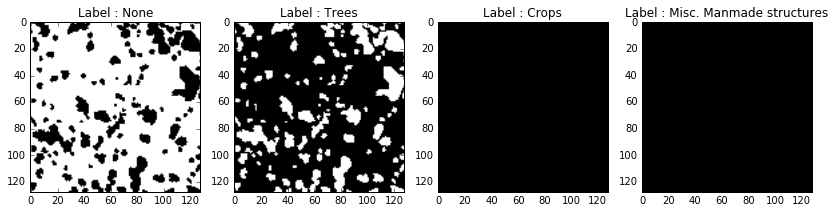

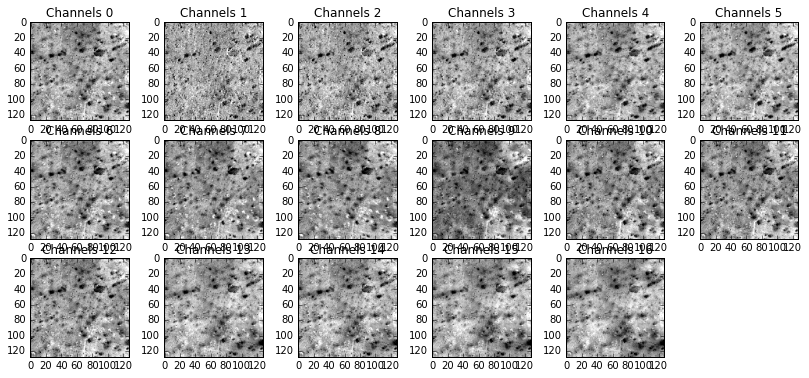

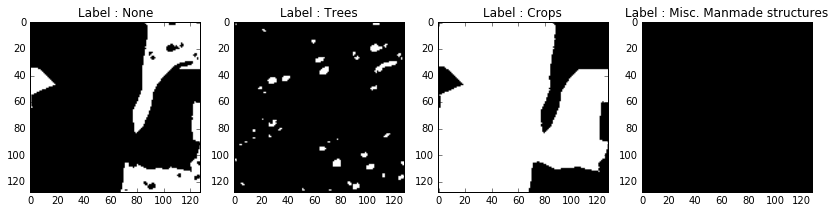

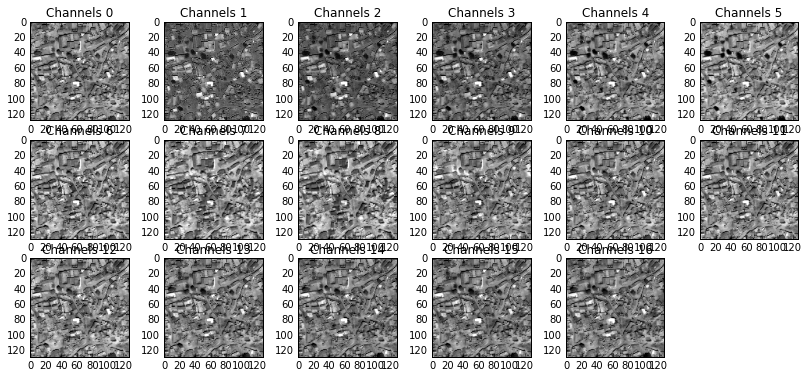

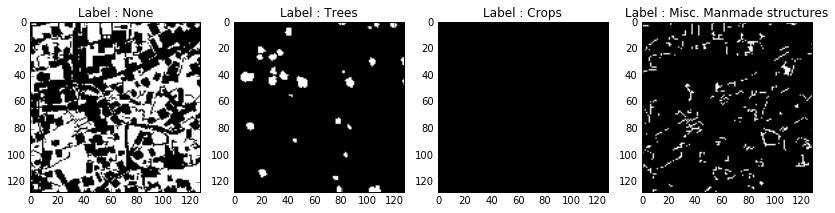

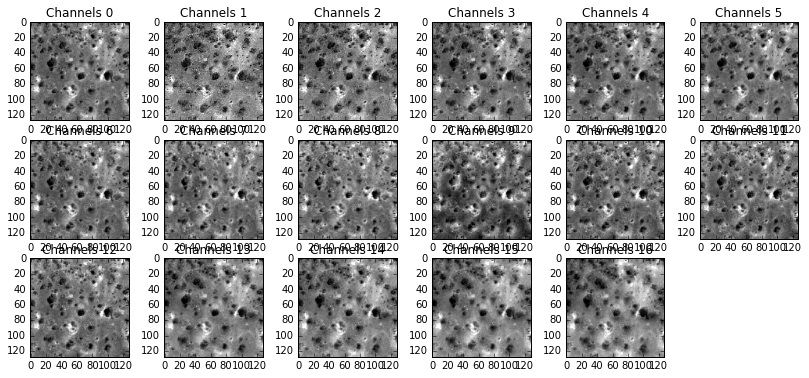

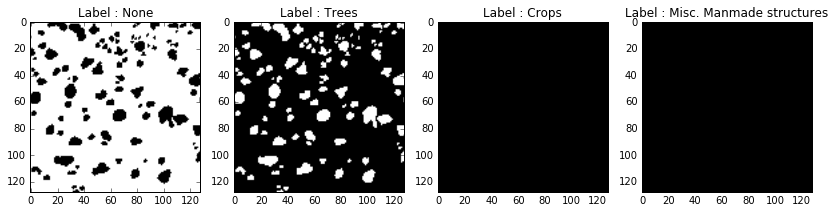

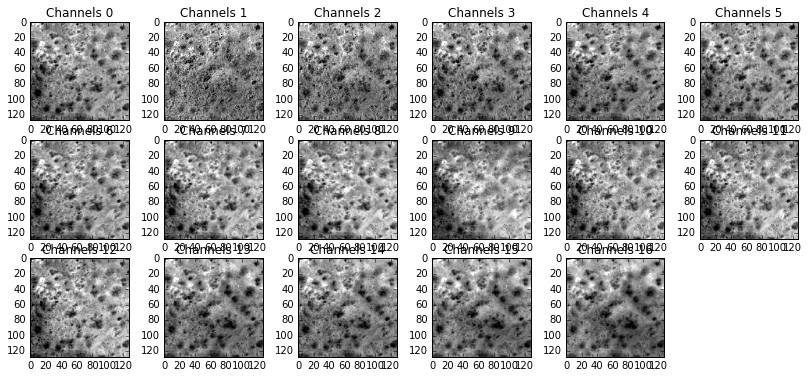

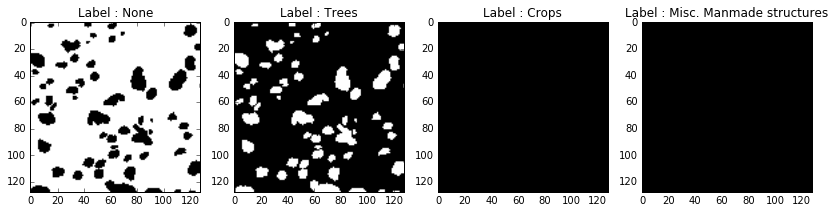

In [16]:
batch_size = 5
for X, Y in generate_images(train_tiles, batch_size, print_tile_id=True):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))
        n, m = 3, int(n_channels * 1.0 / 3.0 + 0.5), 
        for j in range(n_channels):
            plt.subplot(n,m,j+1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 0.5), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [17]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
# earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)
# LearningRateScheduler

In [18]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adadelta(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [19]:
# from keras.callbacks import RemoteMonitor
# rmon = RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})

In [ ]:
foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 16
samples_per_epoch = foo(len(train_tiles))
nb_val_samples = foo(len(val_tiles))


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_tiles, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=20,
    validation_data=generate_images(val_tiles, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=1
)

16 160 160
Epoch 1/20


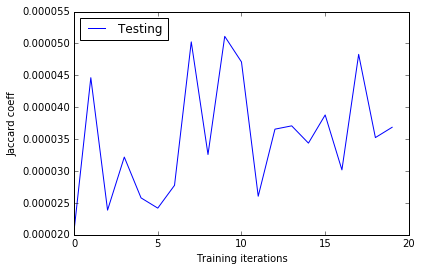

In [49]:
# plt.plot(history.history['val_jaccard_coef_int'])
# plt.ylabel('Jaccard coeff integer')
plt.plot(history.history['val_jaccard_coef'])
plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [37]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5, 4, 256, 256) 3.76119e-08 0.0021728


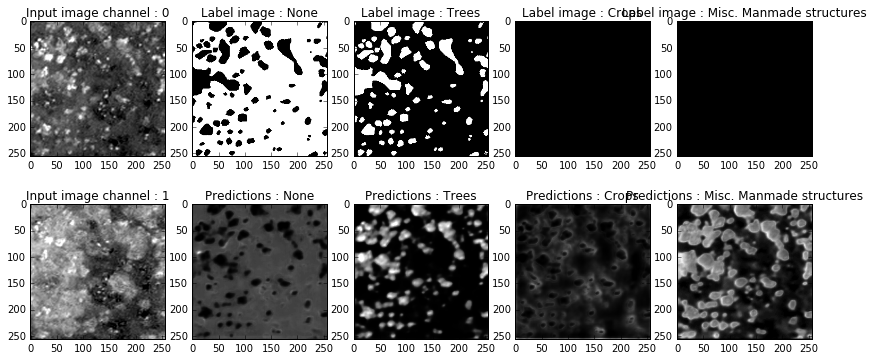

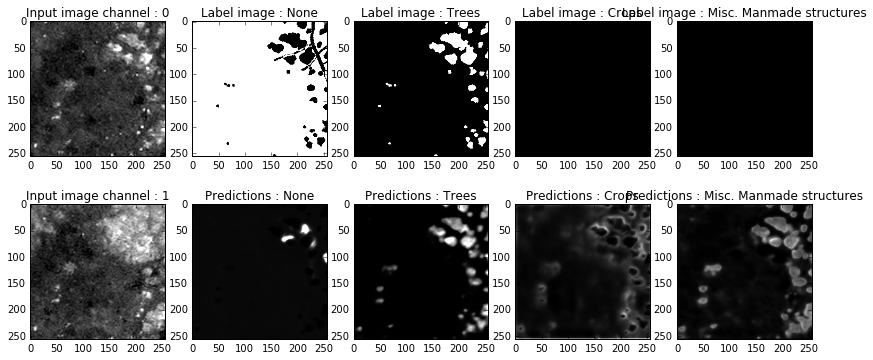

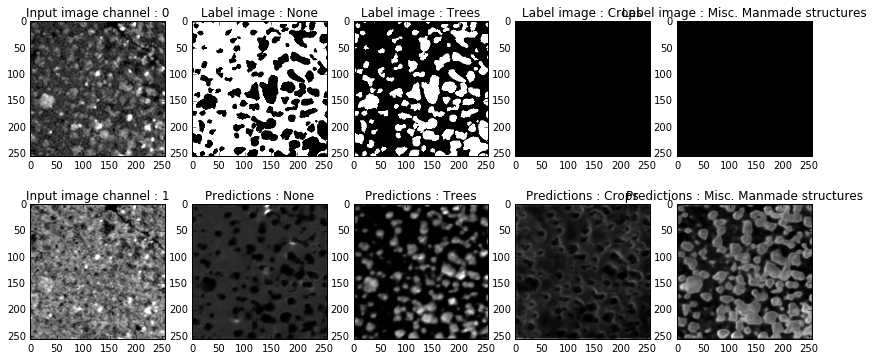

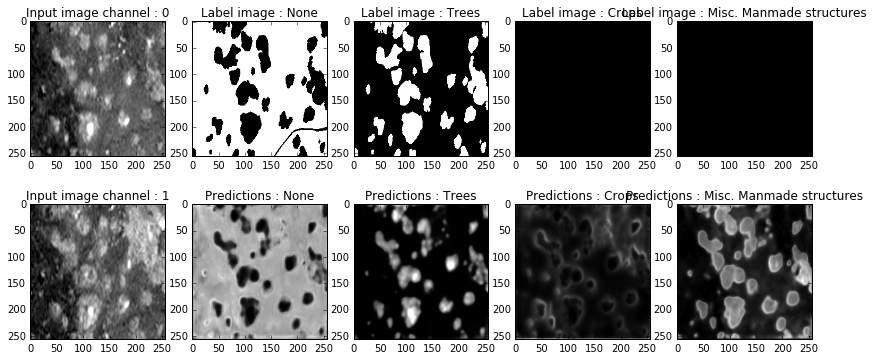

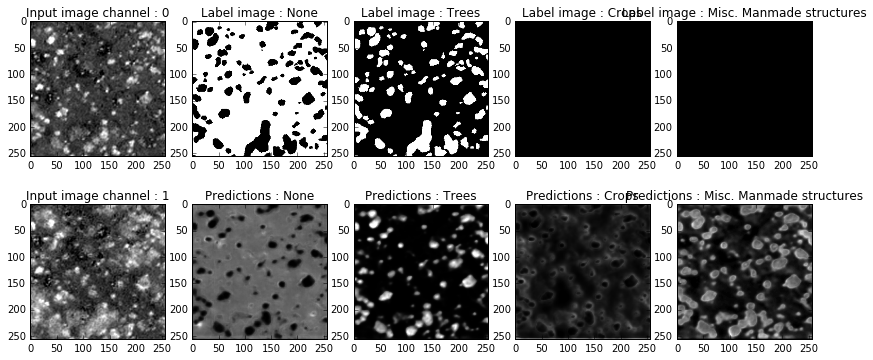

In [54]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


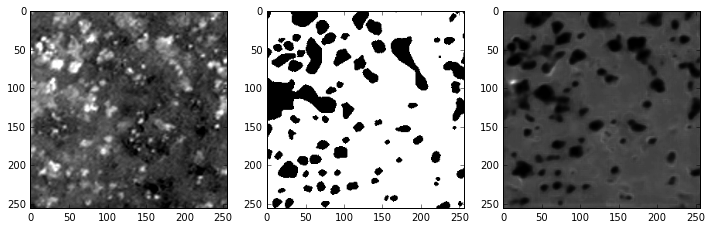

In [55]:
_plot(X, Y, Y_pred, 0, 0)

In [46]:
y = Y_pred[0,2,:,:]
print y.min(), y.max()

2.69546e-07 0.000206497
